In [1]:
import time, os, json
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/home/lizhe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## TinyImageNet

In [2]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


In [3]:
# show classes
for i, names in enumerate(data['class_names']):
    print(i, ''.join('"%s"' % name for name in names))

0 "Egyptian cat"
1 "reel"
2 "volleyball"
3 "rocking chair""rocker"
4 "lemon"
5 "bullfrog""Rana catesbeiana"
6 "basketball"
7 "cliff""drop""drop-off"
8 "espresso"
9 "plunger""plumber's helper"
10 "parking meter"
11 "German shepherd""German shepherd dog""German police dog""alsatian"
12 "dining table""board"
13 "monarch""monarch butterfly""milkweed butterfly""Danaus plexippus"
14 "brown bear""bruin""Ursus arctos"
15 "school bus"
16 "pizza""pizza pie"
17 "guinea pig""Cavia cobaya"
18 "umbrella"
19 "organ""pipe organ"
20 "oboe""hautboy""hautbois"
21 "maypole"
22 "goldfish""Carassius auratus"
23 "potpie"
24 "hourglass"
25 "seashore""coast""seacoast""sea-coast"
26 "computer keyboard""keypad"
27 "Arabian camel""dromedary""Camelus dromedarius"
28 "ice cream""icecream"
29 "nail"
30 "space heater"
31 "cardigan"
32 "baboon"
33 "snail"
34 "coral reef"
35 "albatross""mollymawk"
36 "spider web""spider's web"
37 "sea cucumber""holothurian"
38 "backpack""back pack""knapsack""packsack""rucksack""haversa

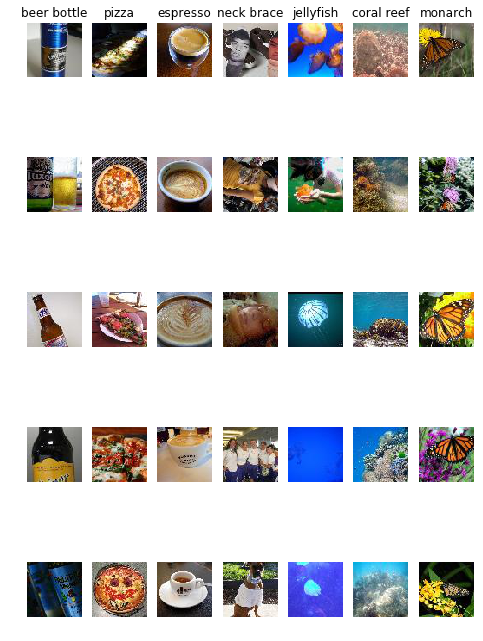

In [32]:
# show some examples in training data
classes_to_show = 7
examples_per_class = 5

class_idxs = np.random.choice(len(data['class_names']), 
                              size=classes_to_show, 
                              replace=False)

# print(class_idxs)

for i, class_idx in enumerate(class_idxs):
    train_idxs, = np.nonzero(data['y_train'] == class_idx)
    train_idxs = np.random.choice(train_idxs, size=examples_per_class, replace=False)
    for j, train_idx in enumerate(train_idxs):
        img = deprocess_image(data['X_train'][train_idx], data['mean_image'])
        plt.subplot(examples_per_class, classes_to_show, 1 + i + classes_to_show * j)
        if j == 0:
            plt.title(data['class_names'][class_idx][0])
        plt.imshow(img)
        plt.gca().axis('off')

plt.rcParams['figure.figsize'] = (8.0, 12.0) # set default size of plots
plt.show()

## load pretrainedCNN

In [33]:
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

batch_size = 100

mask = np.random.randint(data['X_train'].shape[0], size=batch_size)
X, y = data['X_train'][mask], data['y_train'][mask]
y_pred = model.loss(X).argmax(axis=1)
print('Train accuracy:', (y == y_pred).mean())

mask = np.random.randint(data['X_val'].shape[0], size=batch_size)
X, y = data['X_val'][mask], data['y_val'][mask]
y_pred = model.loss(X).argmax(axis=1)
print('Validation accuracy:', (y == y_pred).mean())

Train accuracy: 0.9
Validation accuracy: 0.55


## compute saliency maps

In [34]:
def compute_saliency_maps(X, y, model):
    # X : input images(N, 3, H, W)
    # y:  labels of x, shape of (N, )
    # model: PretrainedCNN to compute the saliency map
    # return:
    #   saliency: an array of (N, H, W) giving the saliency maps
    N = X.shape[0]
    scores, cache = model.forward(X, mode='test')
    dscores = np.zeros_like(scores)
    dscores[range(N), y] = 1 # ground truth saliency map
    dX, _ = model.backward(dscores, cache)
    saliency = np.max(np.abs(dX), axis=1)
    return saliency

In [35]:
def show_saliency_map(mask):
    mask = np.asarray(mask)
    X = data['X_val'][mask]
    y = data['y_val'][mask]
    
    saliency = compute_saliency_maps(X, y, model)
    
    for i in range(mask.size):
        # show origin image
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(X[i], data['mean_image']))
        plt.axis('off')
        plt.title(data['class_names'][y[i]][0])
        # show the saliency map
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i])
        plt.axis('off')
    
    plt.gcf().set_size_inches(10, 4)
    plt.show()

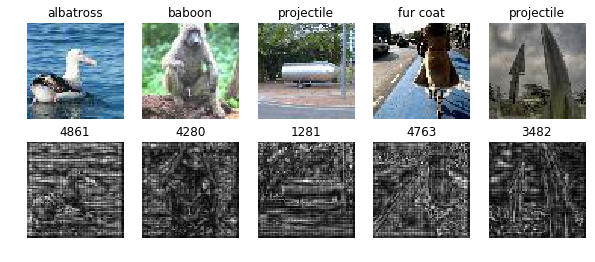

In [36]:
mask = np.random.randint(data['X_val'].shape[0], size=5)
show_saliency_map(mask)

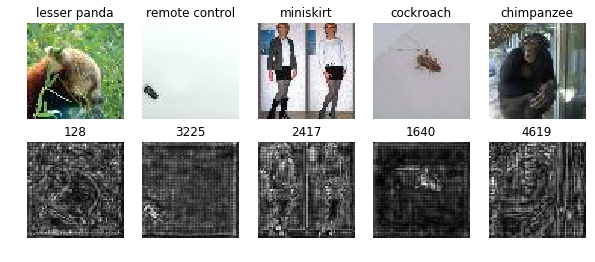

In [37]:
mask = [128, 3225, 2417, 1640, 4619]
show_saliency_map(mask)

# Fooling Images

In [43]:
def make_fooling_image(X, target_y, model):
    """
    generate a fooling image which is close to X, but the target is y
    
    - input:
    - x: (1, 3, 64, 64)
    - target_y: an integer in range [0, 100)
    """
    X_fooling = X.copy()
    N = X.shape[0]
    reg = 5e-5
    from cs231n.layer_basic import softmax_loss
    for i in range(100):
        R = X - X_fooling
#         print(R)
        scores, cache = model.forward(X_fooling, mode='test')
        loss, dscores = softmax_loss(scores, target_y)
        loss += 0.5 * reg * np.sum(R * R)
        print('softmax loss', loss)
        
        y_pred = np.argmax(scores)
        print('current class index is :', y_pred)
        print('target class index is :', target_y)
                
        if y_pred == target_y:
            print('iter num:', i)
            break
        else:
            # update the network
            dX, _ = model.backward(dscores, cache)
            dX += reg * R
#             print('df', df)
            X_fooling -= 600 * dX
    return X_fooling   

# find a correctly classified validation image in network
while True:
    i = np.random.randint(data['X_val'].shape[0])
# for i in range(data['X_val'].shape[0]):
    X = data['X_val'][i:i+1]
    y = data['y_val'][i:i+1]
    y_pred = model.loss(X)[0].argmax()
    if y_pred == y:
#         print(y)
        break

target_y = 67
X_fooling = make_fooling_image(X, target_y, model)
scores = model.loss(X_fooling).argmax()
if scores == y:
    print("you job is not finished")

[47]
softmax loss 13.506315231323242
current class index is : 47
target class index is : 67
softmax loss 6.980020692443848
current class index is : 47
target class index is : 67
softmax loss 1.1263982429504396
current class index is : 67
target class index is : 67
iter num: 2


In [46]:
print(target_y, y)

67 [47]


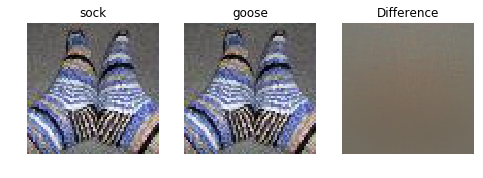

In [47]:
# show origin image
plt.subplot(1, 3, 1)
plt.imshow(deprocess_image(X, data['mean_image']))
plt.axis('off')
plt.title(data['class_names'][y.item()][0])

# show fooling image
plt.subplot(1, 3, 2)
plt.imshow(deprocess_image(X_fooling, data['mean_image'], renorm=True))
plt.title(data['class_names'][target_y][0])
plt.axis('off')

# show difference
plt.subplot(1, 3, 3)
plt.title('Difference')
plt.imshow(deprocess_image(X - X_fooling, data['mean_image']))
plt.axis('off')
plt.show()

## top 1 prediction saliency map

In [48]:
def compute_top_one_saliency_maps(X, y, model):
    # X : input images(N, 3, H, W)
    # y:  labels of x, shape of (N, )
    # model: PretrainedCNN to compute the saliency map
    # return:
    #   saliency: an array of (N, H, W) giving the saliency maps
    N = X.shape[0]
    scores, cache = model.forward(X, mode='test')
    dscores = np.zeros_like(scores)
    dscores[range(N), np.argmax(scores, axis=1)] = 1
    dX, _ = model.backward(dscores, cache)
    saliency = np.max(np.abs(dX), axis=1)
    return saliency

In [49]:
def show_top_one_saliency_map(mask):
    mask = np.asarray(mask)
    X = data['X_val'][mask]
    y = data['y_val'][mask]
    
    saliency = compute_top_one_saliency_maps(X, y, model)
    
    for i in range(mask.size):
        # show origin image
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(X[i], data['mean_image']))
        plt.axis('off')
        plt.title(data['class_names'][y[i]][0])
        # show the saliency map
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i])
        plt.axis('off')
    
    plt.gcf().set_size_inches(10, 4)
    plt.show()

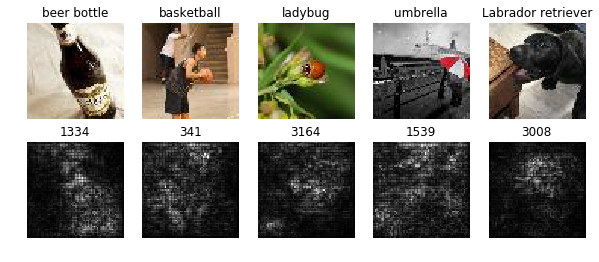

In [50]:
mask = np.random.randint(data['X_val'].shape[0], size=5)
show_saliency_map(mask)

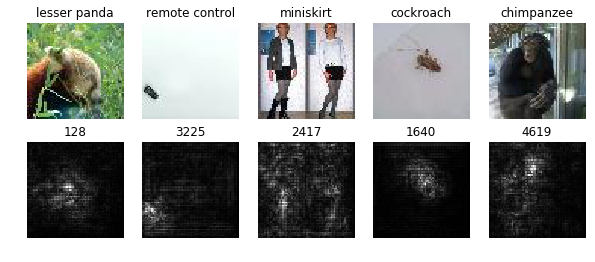

In [51]:
mask = [128, 3225, 2417, 1640, 4619]
show_saliency_map(mask)